In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import yfinance as yf
import random

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from datetime import date, timedelta, datetime
import matplotlib.dates as mdates
import math

In [4]:
data = yf.Ticker("ETH-USD").history(period='5y')

In [5]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-11-20 00:00:00+00:00,148.811005,151.253006,126.360001,130.339005,3134410000,0.0,0.0
2018-11-21 00:00:00+00:00,131.141998,138.889999,125.758003,136.701004,2685930000,0.0,0.0
2018-11-22 00:00:00+00:00,136.811005,137.740005,126.706001,126.706001,1792150000,0.0,0.0
2018-11-23 00:00:00+00:00,126.418999,127.028000,119.558998,123.295998,1998010000,0.0,0.0
2018-11-24 00:00:00+00:00,123.304001,126.788002,110.824997,113.494003,1800960000,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-16 00:00:00+00:00,2059.965820,2088.662354,1940.574219,1960.881592,14651619483,0.0,0.0
2023-11-17 00:00:00+00:00,1961.867554,1990.050537,1910.445435,1961.280762,11881648738,0.0,0.0
2023-11-18 00:00:00+00:00,1961.671265,1971.462280,1921.062378,1963.285034,8064677046,0.0,0.0


In [6]:
def train_test_split(df,window_size,split_ratio):
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    window_size = window_size
    split_ratio = split_ratio
    for i in range(window_size, len(df)):
        X = df.iloc[i-window_size:i, :].values
        Y = df.iloc[i, 1]

        if i < len(df) * split_ratio:
            X_train.append(X)
            Y_train.append(Y)
        else:
            X_test.append(X)
            Y_test.append(Y)
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    return X_train,Y_train,X_test,Y_test

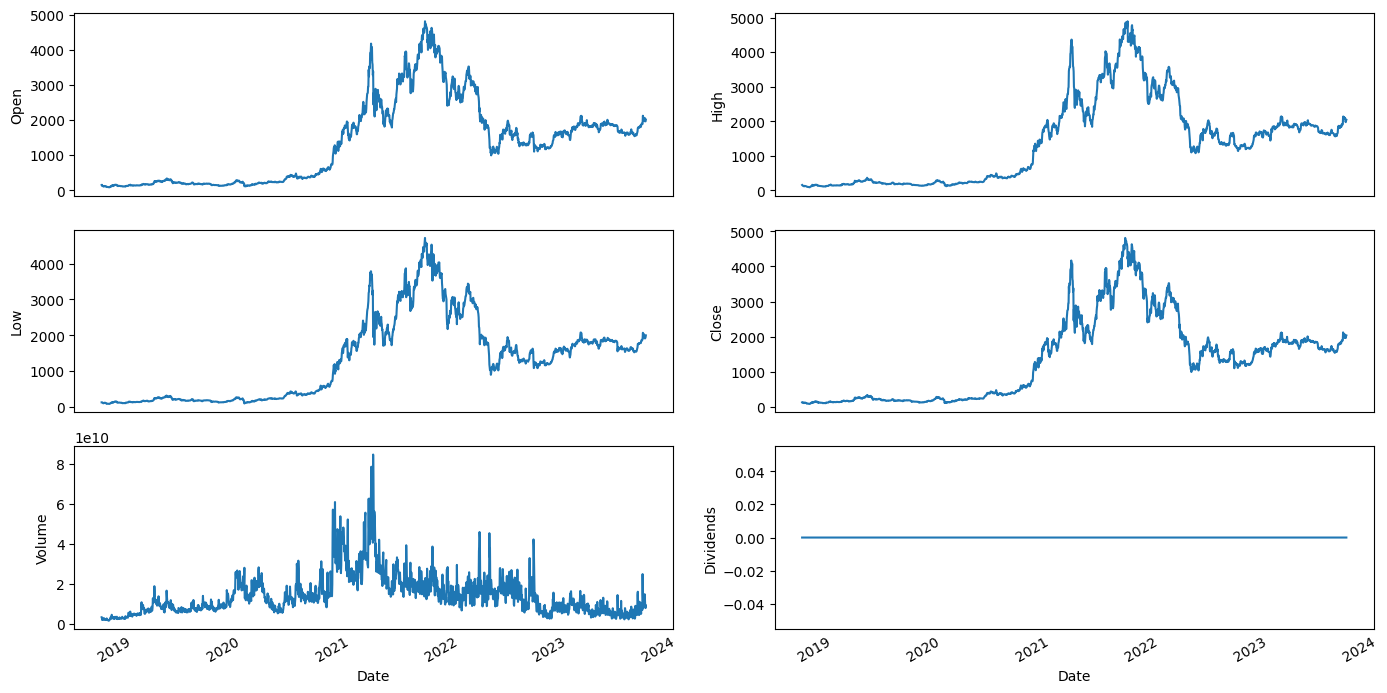

In [7]:
# Plot line charts
df_plot = data.iloc[:,:6].copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sbn.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [8]:
train_df = data.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-11-16 00:00:00+00:00,2088.662354,1940.574219,2059.965820,1960.881592,14651619483,1960.881592
2023-11-17 00:00:00+00:00,1990.050537,1910.445435,1961.867554,1961.280762,11881648738,1961.280762
2023-11-18 00:00:00+00:00,1971.462280,1921.062378,1961.671265,1963.285034,8064677046,1963.285034
2023-11-19 00:00:00+00:00,2015.633911,1944.900879,1963.180054,2013.204468,7716048818,2013.204468
2023-11-20 00:00:00+00:00,2038.425171,1997.021973,2011.853394,2035.265747,9037587456,2035.265747


In [9]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1827, 5)


In [10]:
np_data_scaled

array([[0.01371313, 0.00939119, 0.01365513, 0.00973622, 0.0197409 ],
       [0.01114091, 0.00926131, 0.00991629, 0.01108189, 0.01433667],
       [0.01090165, 0.00946583, 0.01111588, 0.00896778, 0.00356651],
       ...,
       [0.39242146, 0.39658027, 0.39726499, 0.39743328, 0.07915121],
       [0.4016117 , 0.40172318, 0.39758426, 0.40799203, 0.07495019],
       [0.4063536 , 0.41296779, 0.40788377, 0.41265833, 0.09087489]])

In [11]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i, index_Close])
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y


x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1412, 50, 5) (1412,)
(365, 50, 5) (365,)
0.014064705255529823
0.014064705255529823


In [12]:
# Configure the neural network model
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [13]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

                    #callbacks=[early_stop])

Epoch 1/50
89/89 [==============================] - 10s 19ms/step - loss: 0.0036 - val_loss: 2.4726e-04
Epoch 2/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 2.9168e-04
Epoch 3/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 5.6097e-04
Epoch 4/50
89/89 [==============================] - 1s 10ms/step - loss: 8.4159e-04 - val_loss: 1.5516e-04
Epoch 5/50
89/89 [==============================] - 1s 9ms/step - loss: 8.9388e-04 - val_loss: 1.5363e-04
Epoch 6/50
89/89 [==============================] - 1s 9ms/step - loss: 7.9430e-04 - val_loss: 1.3265e-04
Epoch 7/50
89/89 [==============================] - 1s 10ms/step - loss: 6.9391e-04 - val_loss: 7.7989e-04
Epoch 8/50
89/89 [==============================] - 1s 11ms/step - loss: 7.3679e-04 - val_loss: 1.1756e-04
Epoch 9/50
89/89 [==============================] - 1s 13ms/step - loss: 6.0072e-04 - val_loss: 8.8117e-04
Epoch 10/50
89/89 [==============================]

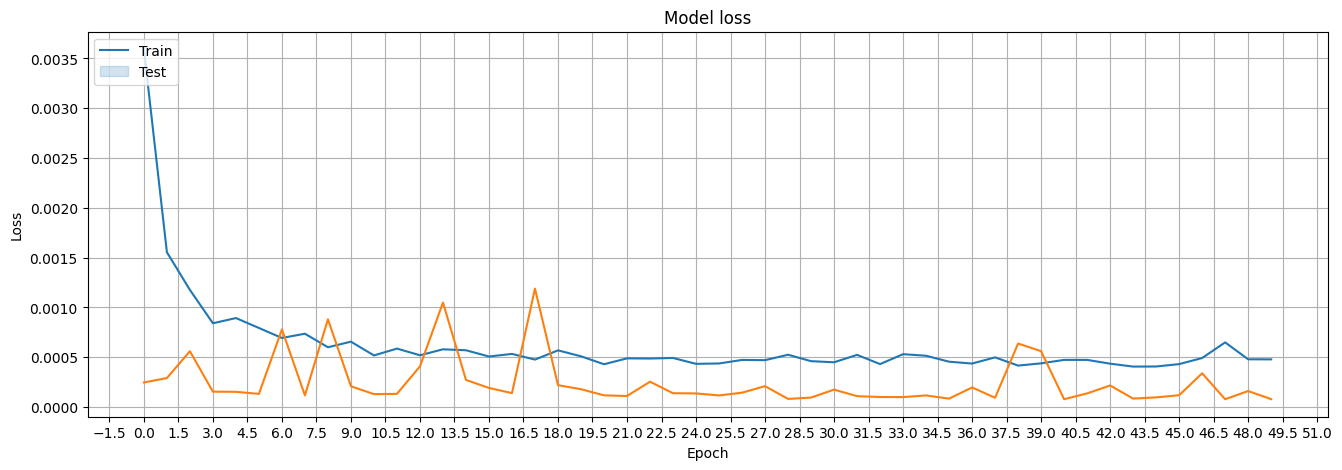

In [14]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sbn.lineplot(data=history.history["loss"])
sbn.lineplot(data=history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [15]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

12/12 [==============================] - 1s 6ms/step
Median Absolute Error (MAE): 28.93
Mean Absolute Percentage Error (MAPE): 1.73 %
Median Absolute Percentage Error (MDAPE): 1.12 %


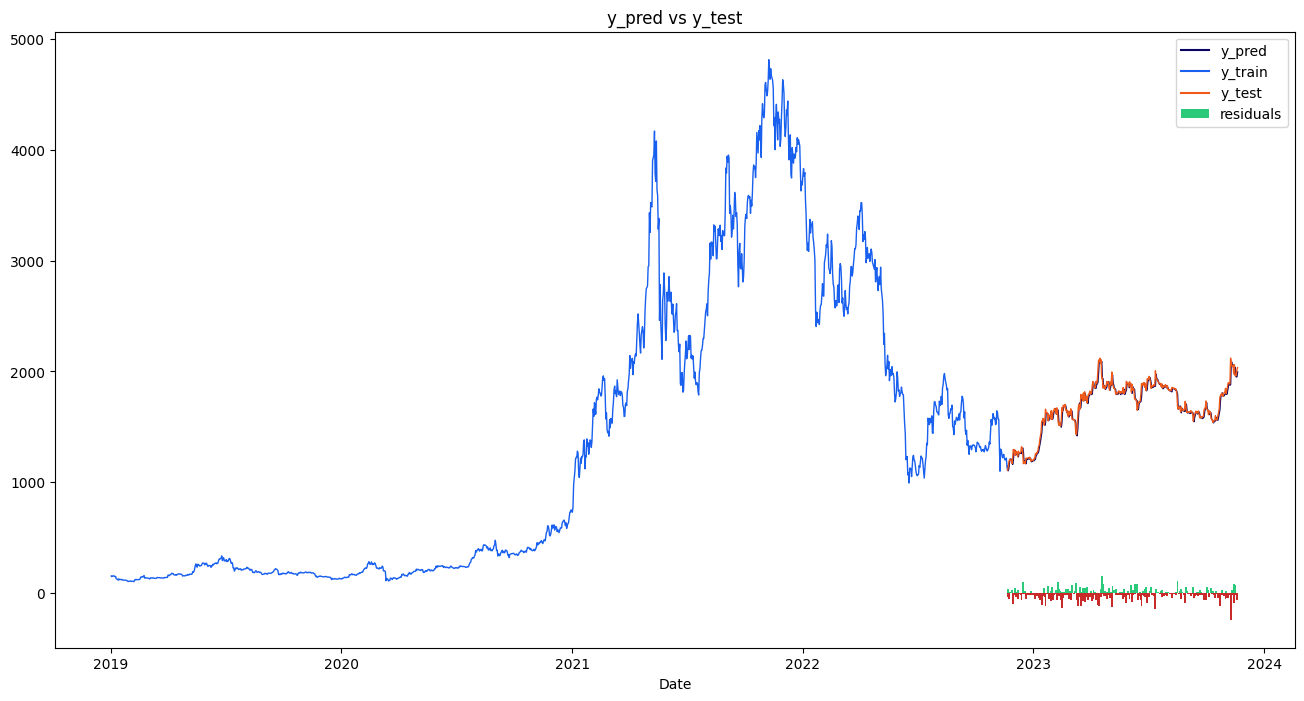

In [16]:

display_start_date = "2019-01-01"
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")

sbn.set_palette(["#090364", "#1960EF", "#EF5919"])
sbn.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

#Implementation of federated learning

In [17]:
#splitting the dataset into 5 clients for a a balanced time gap of 5 years

num_clients = 5
client_data = np.array_split(np_data_scaled, num_clients)

In [18]:
client_data[2].shape

(365, 5)

In [19]:
#Dividing the close price among the respective clients
close_client_data = np.array_split(np_Close_scaled,num_clients)

In [20]:
close_client_data[2].shape

(365, 1)

In [21]:
len(np_data_scaled)

1827

In [22]:
train_data_len

1462

In [23]:
train_data_client_len = math.ceil(client_data[0].shape[0] * 0.8)

In [24]:
#dividing dataset into x_train and y_train
sequence_length = 50
train_per_client={}
test_per_client={}
train_data_client_len = math.ceil(client_data[0].shape[0] * 0.8)

train_data0 = client_data[0][0:train_data_client_len, :]
test_data0 = client_data[0][train_data_client_len - sequence_length:, :]

train_data1 = client_data[1][0:train_data_client_len, :]
test_data1 = client_data[1][train_data_client_len - sequence_length:, :]

train_data2 = client_data[2][0:train_data_client_len, :]
test_data2= client_data[2][train_data_client_len - sequence_length:, :]

train_data3 = client_data[3][0:train_data_client_len, :]
test_data3 = client_data[3][train_data_client_len - sequence_length:, :]

train_data4 = client_data[4][0:train_data_client_len, :]
test_data4 = client_data[4][train_data_client_len - sequence_length:, :]

train_per_client = {'Client_0':train_data0,
                    'Client_1':train_data1,
                    'Client_2':train_data2,
                    'Client_3':train_data3,
                    'Client_4':train_data4}

test_per_client = {'Client_0':test_data0,
                    'Client_1':test_data1,
                    'Client_2':test_data2,
                    'Client_3':test_data3,
                    'Client_4':test_data4}

In [25]:
len(train_per_client['Client_0'])

293

In [26]:
len(test_per_client['Client_0'])

123

In [27]:
X_train0,Y_train0 = partition_dataset(sequence_length,train_per_client['Client_0'])
X_train1,Y_train1 = partition_dataset(sequence_length,train_per_client['Client_1'])
X_train2,Y_train2 = partition_dataset(sequence_length,train_per_client['Client_2'])
X_train3,Y_train3 = partition_dataset(sequence_length,train_per_client['Client_3'])
X_train4,Y_train4 = partition_dataset(sequence_length,train_per_client['Client_4'])


X_test0,Y_test0 = partition_dataset(sequence_length,test_per_client['Client_0'])
X_test1,Y_test1 = partition_dataset(sequence_length,test_per_client['Client_1'])
X_test2,Y_test2 = partition_dataset(sequence_length,test_per_client['Client_2'])
X_test3,Y_test3 = partition_dataset(sequence_length,test_per_client['Client_3'])
X_test4,Y_test4 = partition_dataset(sequence_length,test_per_client['Client_4'])

In [28]:
X_train0.shape

(243, 50, 5)

In [29]:
X_test0.shape

(73, 50, 5)

In [30]:
Y_train0.shape

(243,)

In [31]:

# Function for creating for model for different
def Create_model(x_train12):
    model = Sequential()
    n_neurons = x_train12.shape[1] * x_train12.shape[2]
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train12.shape[1], x_train12.shape[2])))
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))

    return model


In [32]:
client_models = []

In [33]:
client_models.append(Create_model(X_train0))
client_models.append(Create_model(X_train1))
client_models.append(Create_model(X_train2))
client_models.append(Create_model(X_train3))
client_models.append(Create_model(X_train4))

In [34]:
client_models

In [35]:
for i in range(num_clients):
    client_models[i].compile(optimizer='adam', loss='mse')

In [36]:
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history0 = client_models[0].fit(X_train0, Y_train0,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test0, Y_test0)
                   )


Epoch 1/50
16/16 [==============================] - 4s 60ms/step - loss: 4.3805e-04 - val_loss: 3.9096e-05
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 4.6895e-05 - val_loss: 1.9205e-05
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6923e-05 - val_loss: 2.3985e-05
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4594e-05 - val_loss: 1.7498e-05
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4319e-05 - val_loss: 1.0938e-05
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4491e-05 - val_loss: 1.2818e-05
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 1.2131e-05 - val_loss: 8.3827e-06
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4254e-05 - val_loss: 1.3914e-05
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 1.2520e-05 - val_loss: 1.0546e-05
Epoch 10/50
16/16 [==================

In [37]:
history1 = client_models[1].fit(X_train1, Y_train1,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test1, Y_test1)
                   )

Epoch 1/50
16/16 [==============================] - 5s 59ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 1.8530e-04 - val_loss: 2.7528e-04
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 5.3356e-05 - val_loss: 5.5453e-05
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 4.7200e-05 - val_loss: 6.7469e-05
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 3.3731e-05 - val_loss: 3.3428e-05
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 2.9500e-05 - val_loss: 1.9312e-05
Epoch 7/50
16/16 [==============================] - 0s 10ms/step - loss: 3.1105e-05 - val_loss: 4.1015e-05
Epoch 8/50
16/16 [==============================] - 0s 11ms/step - loss: 2.9023e-05 - val_loss: 2.2666e-05
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 2.5874e-05 - val_loss: 2.9429e-05
Epoch 10/50
16/16 [==========================

In [38]:
history2 = client_models[2].fit(X_train2, Y_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test2, Y_test2)
                   )

Epoch 1/50
16/16 [==============================] - 5s 60ms/step - loss: 0.0543 - val_loss: 0.0229
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0078 - val_loss: 0.0047
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 8/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 10/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 11/

In [39]:
history3 = client_models[3].fit(X_train3, Y_train3,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test3, Y_test3)
                   )

Epoch 1/50
16/16 [==============================] - 4s 72ms/step - loss: 0.0500 - val_loss: 7.9262e-04
Epoch 2/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0050 - val_loss: 5.7354e-04
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0024 - val_loss: 5.9959e-04
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0017 - val_loss: 6.2565e-04
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0016 - val_loss: 5.0014e-04
Epoch 6/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 6.5203e-04
Epoch 7/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0016 - val_loss: 6.6169e-04
Epoch 8/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0017 - val_loss: 5.2986e-04
Epoch 9/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0016 - val_loss: 7.9002e-04
Epoch 10/50
16/16 [==============================] - 0s 17ms/step - loss:

In [40]:
history4 = client_models[4].fit(X_train4, Y_train4,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test4, Y_test4)
                   )

Epoch 1/50
16/16 [==============================] - 5s 92ms/step - loss: 0.0164 - val_loss: 0.0010
Epoch 2/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 4.4536e-04
Epoch 3/50
16/16 [==============================] - 0s 20ms/step - loss: 3.2547e-04 - val_loss: 3.4154e-04
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 2.4158e-04 - val_loss: 4.0283e-04
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 2.4883e-04 - val_loss: 3.4502e-04
Epoch 6/50
16/16 [==============================] - 0s 17ms/step - loss: 2.3674e-04 - val_loss: 2.9270e-04
Epoch 7/50
16/16 [==============================] - 0s 19ms/step - loss: 2.3286e-04 - val_loss: 3.1593e-04
Epoch 8/50
16/16 [==============================] - 0s 11ms/step - loss: 2.4721e-04 - val_loss: 2.8215e-04
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 2.3193e-04 - val_loss: 2.7136e-04
Epoch 10/50
16/16 [==============================

In [41]:
client_models[4].get_weights()

[array([[ 1.6532779e-02, -4.6501830e-02, -2.6919089e-02, ...,
          7.2047345e-02, -6.3283488e-02, -2.5267104e-02],
        [-5.4367464e-03, -4.2127736e-02, -2.3411404e-02, ...,
          2.8575337e-02,  8.1725102e-03, -6.1127443e-02],
        [ 7.6068486e-03, -2.7356664e-02, -2.9477784e-02, ...,
          4.8686088e-05, -2.0588899e-03,  4.9756527e-02],
        [ 3.4307417e-02, -2.9423578e-02,  7.7504434e-02, ...,
          4.0744595e-02, -5.2074813e-03, -3.0771010e-02],
        [-6.3249409e-02, -5.4429717e-02,  8.2217462e-02, ...,
         -3.5103094e-03, -8.6975284e-02,  1.0742775e-02]], dtype=float32),
 array([[-0.01403342, -0.03659555,  0.00889584, ...,  0.02658322,
         -0.04197731, -0.04953644],
        [-0.05783135, -0.026129  , -0.05056408, ...,  0.02130691,
          0.04197975,  0.0409181 ],
        [ 0.00726656,  0.00173037,  0.01507626, ...,  0.02547964,
         -0.04196449,  0.02036926],
        ...,
        [ 0.0228757 , -0.02281857,  0.00685766, ..., -0.02459682

In [42]:
client_weights = []
for i in range(num_clients):
    x = client_models[i].get_weights()
    client_weights.append(x)


In [43]:
global_weights = []

In [44]:
global_weights = np.average(client_weights,axis=0)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:509: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


In [45]:
global_weights

array([array([[-0.02771318, -0.02590943,  0.00303953, ...,  0.01808311,
                0.00462767,  0.04891118],
              [ 0.00250201,  0.01514661,  0.0233798 , ...,  0.04172176,
                0.00735962, -0.01361859],
              [ 0.00689619, -0.01189436, -0.0032129 , ...,  0.00020731,
               -0.02168706,  0.02604409],
              [ 0.02396871,  0.01066702,  0.00821846, ...,  0.02284865,
                0.00837294,  0.03138165],
              [-0.00414041, -0.03255012, -0.00023885, ...,  0.01694321,
               -0.03699939,  0.01728574]], dtype=float32)              ,
       array([[-0.00198036, -0.03077059,  0.0069338 , ...,  0.00566416,
               -0.00826715, -0.00206128],
              [ 0.00616494, -0.02363183,  0.01036061, ...,  0.01309518,
                0.01728389, -0.00102858],
              [ 0.00026226,  0.01246718, -0.00543516, ...,  0.00692402,
               -0.0015969 ,  0.02013928],
              ...,
              [-0.01751313, -0.0102064

In [46]:
for i in range(num_clients):
    client_models[i].set_weights(global_weights)

In [47]:
client_models[4].get_weights()

[array([[-0.02771318, -0.02590943,  0.00303953, ...,  0.01808311,
          0.00462767,  0.04891118],
        [ 0.00250201,  0.01514661,  0.0233798 , ...,  0.04172176,
          0.00735962, -0.01361859],
        [ 0.00689619, -0.01189436, -0.0032129 , ...,  0.00020731,
         -0.02168706,  0.02604409],
        [ 0.02396871,  0.01066702,  0.00821846, ...,  0.02284865,
          0.00837294,  0.03138165],
        [-0.00414041, -0.03255012, -0.00023885, ...,  0.01694321,
         -0.03699939,  0.01728574]], dtype=float32),
 array([[-0.00198036, -0.03077059,  0.0069338 , ...,  0.00566416,
         -0.00826715, -0.00206128],
        [ 0.00616494, -0.02363183,  0.01036061, ...,  0.01309518,
          0.01728389, -0.00102858],
        [ 0.00026226,  0.01246718, -0.00543516, ...,  0.00692402,
         -0.0015969 ,  0.02013928],
        ...,
        [-0.01751313, -0.01020642,  0.01082419, ..., -0.00059308,
         -0.00404004, -0.01649116],
        [ 0.00262123,  0.01215002, -0.01674179, ...,